# prepare data - mnist
1. two ways:<br>
> 1. sklearn fetch_openml <br>
> 2. download from official websites <br> arff format

In [3]:
from os import path

print(path.abspath(" "))

/Users/collinsliu/jupyter/machine_learning/chapters/ 


In [7]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784') 

In [6]:
mnist.details

{'id': '554',
 'name': 'mnist_784',
 'version': '1',
 'description_version': '1',
 'format': 'ARFF',
 'creator': ['Yann LeCun', 'Corinna Cortes', 'Christopher J.C. Burges'],
 'upload_date': '2014-09-29T03:28:38',
 'language': 'English',
 'licence': 'Public',
 'url': 'https://www.openml.org/data/v1/download/52667/mnist_784.arff',
 'file_id': '52667',
 'default_target_attribute': 'class',
 'tag': ['AzurePilot',
  'OpenML-CC18',
  'OpenML100',
  'study_1',
  'study_123',
  'study_41',
  'study_99',
  'vision'],
 'visibility': 'public',
 'status': 'active',
 'processing_date': '2020-11-20 20:12:09',
 'md5_checksum': '0298d579eb1b86163de7723944c7e495'}

In [10]:
from scipy.io.arff import loadarff

# 'url': 'https://www.openml.org/data/v1/download/52667/mnist_784.arff'
mnist_path = "../data/mnist_784.arff"
mnist_raw = loadarff(mnist_path)

AttributeError: 'tuple' object has no attribute 'meta'

In [15]:
mnist_data = mnist_raw[0]
mnist_target = mnist_raw[1]

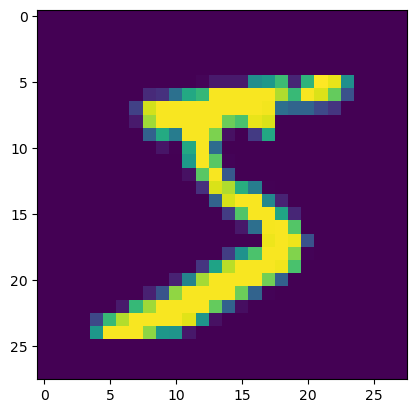

In [48]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# plt.imshow(np.array(mnist_data[0],dtype=np.int32))
type(np.array(mnist_data[0].tolist()))
plt.imshow(np.array(mnist_data[0].tolist(),dtype=np.float64)[:-1].reshape(28,28))

In [64]:
# data description:
# X - 70000 28*28 ndarray,which is flatten into 784 (70000,784) DF
# y - 70000 labels from 0-9
X, y = mnist["data"], mnist["target"]
X.index

RangeIndex(start=0, stop=70000, step=1)

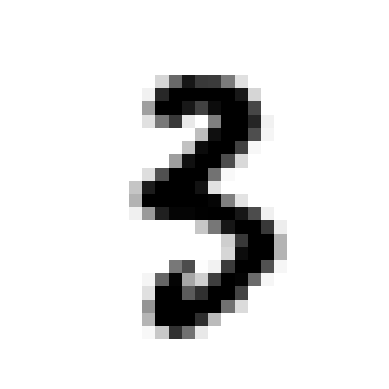

In [67]:
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

some_digit = X.iloc[45000]
some_digit_image = some_digit.values.reshape(28,28)

plt.imshow(some_digit_image,  cmap=plt.cm.binary,
          interpolation="nearest")
plt.axis("off")
plt.grid(alpha=0)
plt.show()